In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# read in competition data
phil = open('busy_day.in','r')
data = phil.read().split("\n")
phil.close()

# extract data into usable variables

map_data = data[0]
product_data = data[2]
num_warehouses = int(data[3])



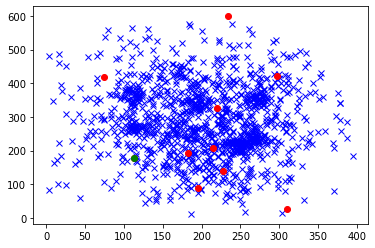

In [3]:

# This cell is a guide to show the locations of orders and warehouses on the map

warehouse_locations = []

for i in range(0,num_warehouses*2,2):
    warehouse_locations.append(data[4+i])
    
xlocs = [int(x.split()[0]) for x in warehouse_locations]
ylocs = [int(x.split()[1]) for x in warehouse_locations]

# Map data is first line, product data is 2nd and 3rd line, number of warehouses is 4th line.
# For each warehouse there will be 2 lines associated, so the number of jobs will
# be on line 1+2+1 + (num_warehouses*2) + 1. Python zero indexes so -1 from this to get correct line.

job_start = 4+(num_warehouses*2)

num_jobs = int(data[job_start])

# each job is described over 3 lines, so step by 3 each time to extract just the locations

job_locations = []
for i in range(0,num_jobs*3,3):
    job_locations.append(data[job_start+1+i])

# plot the warehouse locations to give representation of distribution

job_locations_x = [int(x.split()[0]) for x in job_locations]
job_locations_y = [int(x.split()[1]) for x in job_locations]

plt.plot(job_locations_x,job_locations_y, marker='x', linestyle = 'none',color='blue')
plt.plot(xlocs,ylocs, marker='o', linestyle = 'none',color='red')

# colour 'warehouse 0' in different colour to show where drones start

plt.plot(xlocs[0],ylocs[0], marker='o', linestyle = 'none',color='green')




# Approach
We will first assign orders to their closest warehouses based purely on distance.
Following this, we will evaluate the stock of each warehouse and compare it to the required stock for each of these assigned orders.
We will identify excess stock that is not required for each warehouse's assigned orders.
For each warehouse, we will then create new orders to redistribute stock from other warehouse's excess stock.

As a check for this logic, we will then loop over the requested items to make sure that enough requested stock exists in each warehouse to meet all assigned orders.

This will provide us with 2 lists of orders that will complete every shipment - a redistribution order list, and a delivery order list.
We will assign drones to meet the redistribution list first, based on their current location and nearest warehouse.
This first implementation will do single visits from warehouse -> delivery location -> warehouse - whilst a more efficient solution would be to see if there is remaining space in the drone and attempt delivery of other nearby orders.

## Object definitions and hierarchy

### Warehouse Object
This contains a unique ID, its location, its current stock and a list of Order objects that have been assigned to it.
The object contains methods to identify excess stock based on the orders assigned.

### Order Object
This contains a unique ID, the destination, its assigned warehouse ID and the list of Product objects that make up the complete order, and a list of shipment objects that can be used by the drones to complete the order (taking into account the weights of the drones).

### Product Object
This contains the ID of the product, and it's associated weight.

### Shipment Object
This contains the ID of the shipment tied to each order, the destination of the shipment, the origin of the shipment, and product IDs.

Are there redundant objects in here? Possibly - Order objects are transient as they are relitively quickly used to generate shipment objects, which are the actionable objects used for Drone distribution.
This solution is not going to be the fastest way to solve the problem, but aims TO solve the problem, and optimisation can be made at a later date if the needs arise. Better to get a working solution now and fix later rather than try to fix problems that haven't presented themselves yet.


In [4]:
num_warehouses

10

In [6]:
# get locations of warehouses and jobs in numpy format for distance checking

wlocs = np.zeros([len(xlocs),2])
for c,val in enumerate(wlocs):
    val[0] = xlocs[c]
    val[1] = ylocs[c]
    
jlocs = np.zeros([num_jobs,2])
for c,val in enumerate(jlocs):
    val[0] = job_locations_x[c]
    val[1] = job_locations_y[c]

def npdistance(a,b):
    return np.linalg.norm(a-b)

# cache the closest warehouses - the order they will request more stock from
closest_warehouse = np.empty(num_jobs)

for j,job in enumerate(jlocs):
    closest_distance = np.Infinity
    for c,warehouse in enumerate(wlocs):
        dist = npdistance(job,warehouse)
        if dist < closest_distance:
            closest_distance = dist
            closest_warehouse[j] = c

# create a dictionary of product objects and their weights

class Product:
    def __init__(self,
    id_IN,
    weight_IN):
        self.id = id_IN
        self.weight = weight_IN
product_data = {}

for pid, weights in enumerate(data[2].split()):
    #print(pid,weights)
    new_product = Product(pid,int(weights))
    product_data.update({new_product.id:new_product})


# define warehouse, order and shipment objects

''' Warehouse object. This object keeps track of the current stock at the warehouse and a list of its assigned orders.
    It also contains the logic for calculating how much stock needs to be requested to itself to meed demand from assigned orders.'''
class Warehouse:
    def __init__(self,id_IN,location_IN,stock_IN,assigned_orders_IN):
        self.id = id_IN # a unique ID of the warehouse
        self.location = location_IN # a numpy list of size [1,2] containing the vector location
        self.stock = stock_IN # a np array of current stock of each product, values = current stock
        self.assigned_orders = assigned_orders_IN # a list of Order objects


        self.request = [] # items warehouse needs to request to meet demand
        self.excess = []  # excess items not needed
        self.diff = []    # difference between requested and initial stock
        self.demand = []  # items needed to fulfill orders regardless of current stock

    # string representation of the object
    def __repr__(self)->str:
        out_str  = f"iD: {self.id}\nLocation: {self.location}\n"
        out_str += f"Current Stock: {self.stock}"
    
        return out_str

    ''' Calculate the stock needed for all assigned orders '''
    def stockCalculation(self):
        self.demand = np.zeros(int(data[1]), dtype = np.intc)
        #supply = self.stock
        for order in self.assigned_orders:
            prods = order.listOfProductIDs()
            for prod in prods:
                self.demand[prod] += 1
        self.diff = self.stock-self.demand

        self.request = np.zeros_like(self.demand)
        self.excess  = np.zeros_like(self.demand)

        # populate [request] with products needed to be added to stock to meed demand,
        # and [excess] with items that are not needed
        for c,item in enumerate(self.diff):
            if item < 0:
                self.request[c] = -item
            elif item > 0:
                self.excess[c] = item
''' This class describes complete customer orders and their assigned warehouse. '''
class Order:
    def __init__(self,id_IN,location_IN,assigned_warehouse_id_IN,product_objects_IN):
        self.id = id_IN # a unique ID of the order
        self.location = location_IN # a numpy list of size [1,2] containing the vector location
        self.assigned_warehouse_ID = assigned_warehouse_id_IN # the unique ID of the warehouse
        self.product_objects = product_objects_IN # a list of Product objects that make up this order

        self.completed = False # bool to declare if all products have been shipped to this order
        self.shipments = [] # a list of shipment objects that can be carried by drones to complete the order

    def __repr__(self)->str:
        out_str  = f"iD: {self.id}\nDestination: {self.location}\n"
        out_str += f"Requested Products: {self.product_objects}\n"
        out_str += f"Assigned warehouse iD: {self.assigned_warehouse_ID}\n"
        return out_str

    def listOfProductIDs(self):
        retval = [int(x.id) for x in self.product_objects]
        return retval

    ''' create shipment objects from this order in a semi-optimal way'''
    def createShipments(self):
        # We should create shipments based on maximising the weights that each drone can carry.
        pass
        

''' WIP shipment object '''
class Shipment:
    def __init__(self,
    id_IN,
    destination_IN,
    assigned_warehouse_id_IN,
    product_objects_IN):
        self.Order_id = id_IN # a unique ID of the order this shipment is tied to
        self.destination = destination_IN # a numpy list of size [1,2] containing the vector location
        self.assigned_warehouse_ID = assigned_warehouse_id_IN # the unique ID of the warehouse
        self.product_objects = product_objects_IN # a list of Product objects that make up this shipment

        self.origin = all_warehouses[assigned_warehouse_ID].location # the origin of the shipment



In [7]:

# list of warehouse objects and delivery orders
all_warehouses = []
delivery_orders = []


# First loop through all orders and create an object with all information
# num_jobs = int(data[job_start+1]) - already calculated earlier
for i in range(0,num_jobs*3,3):
    #job locations is at (data[25+i])
    #number of products in job is (data[25+i+1])
    #list of jobs is at (data[25+i+2])

    order_id = int(i/3) #needed because we're stepping by 3 each time
    order_location = np.array(data[job_start+1+i].split(),dtype=np.intc)
    order_assigned_warehouse = closest_warehouse[order_id]
    requested_products = [int(x) for x in data[job_start+1+i+2].split()]
    order_products = [Product(x,product_data[x]) for x in requested_products]
    this_order = Order(order_id,order_location,order_assigned_warehouse,order_products)
    delivery_orders.append(this_order)

# Create warehouse objects and assign the list of orders
for i in range(0,num_warehouses):

    wh_id = int(i)#needed because we're stepping by 2 each time
    wh_loc = np.array(data[4+(i*2)].split(),dtype=np.intc)
    wh_stock = np.array(data[4+(i*2)+1].split(),dtype=np.intc)
    list_of_orders = []
    for ord in delivery_orders:
        if ord.assigned_warehouse_ID == i:
            list_of_orders.append(ord)
    #print(len(list_of_orders))

    all_warehouses.append(Warehouse(i,wlocs[i],wh_stock,list_of_orders))

In [8]:
# calculate the stock redistribution requirements

for wh in all_warehouses:
    wh.stockCalculation()

warehouse_neighbours = [] #list of lists of clostest neighbours for each other warehouse

# for each warehouse
for wh in all_warehouses:
    myloc = wh.location
    closest_neighbours = {}
    for count,neigh in enumerate(all_warehouses):
        if (neigh != wh):
            closest_neighbours[count] = npdistance(myloc,neigh.location)
            
    # from the dictionary, sort based on distance and make a list from the keys
    sortedl = [k for k, v in sorted(closest_neighbours.items(), key=lambda item: item[1])]
        
    warehouse_neighbours.append(sortedl)


redist_orders = []

for count,wh in enumerate(all_warehouses):
    my_request = wh.request
    #print(my_request)
    # create an order for distribution from each neighbour until my_demand is all zeroes
    for neighbour in warehouse_neighbours[count]:
        neighbourw = all_warehouses[neighbour]
        # if requests haven't been satisfied
        #print("requesting items from warehouse", neighbour, "for warehouse", count)
        if not all(item == 0 for item in my_request):
            #print("requests not all zero for wh", count)
            # for each product in demand list
            for prodID,request_level in enumerate(my_request):

                # if the neighbour has excess of a product we request
                if neighbourw.excess[prodID] > 0 and request_level > 0:
                    #print(neighbourw.excess[prodID], request_level)
                    # request either the all of the excess, or what we demand, whichever is smallest
                    req_prod_excess = np.amin([neighbourw.excess[prodID],request_level])
                    #print(req_prod_excess,neighbourw.excess[prodID],request_level)
                    req_prod_list = [prodID for x in range(req_prod_excess)]
                    #print(req_prod_list)
                    redist_orders.append(Order(id_IN=len(redist_orders),
                                                location_IN =neighbourw.location,
                                                assigned_warehouse_id_IN=neighbourw.id,
                                                product_objects_IN=req_prod_list))
                    neighbourw.excess[prodID] -= req_prod_excess
                    my_request[prodID] -= req_prod_excess
                    #print(my_request[prodID])
                    #print("(end of adjustment for this prod from this wh)")
    #print(my_demand)
    #print(my_request)
    

In [9]:
# Safety test to make sure that there's no more demand anywhere
for count,wh in enumerate(all_warehouses):
    if not all(item == 0 for item in wh.request):
        print("ERROR - not all request is satisfied for warehouse", count)
        for count,prod in enumerate(wh.request):
            if (prod != 0):
                print("ID:", count, "Missing", prod)

We now have 2 arrays of orders we would like fufulled - delivery_orders[] contains the orders to complete the deliveries once items have been redistributed, and redist_orders[] which contains the first round of orders needed to redistribute the goods.
Each of these orders needs to be broken down into Shipment objects which are light enough to be carried by a single drone. 

In [10]:
print("Number of delivery orders and number of redistribution orders:")
print(len(delivery_orders))
print(len(redist_orders))


Number of delivery orders and number of redistribution orders:
1250
1890


In [11]:
# parameter keeping track of the current Turn
global_turn = 0


In [12]:
product_data[0].weight

73

In [14]:
#integrating John's work on Drone class

class DroneOverWeightError(Exception):
  pass

class DroneUnderWeightError(Exception):
  pass

class Drone():

  def __init__(self, 
               coords: list, 
               id: int,
               ) -> None:
    self.coords = coords
    self.id = id
    
    self.max_weight = int(data[0].split()[-1]) # last item of the first line input

    self.busy_until = 0 # if > simulation.step, then drone is not free

    self.inventory = {} # inventory stored as product_id:number_carried
    self.command_history = [] #list of all commands stored

  @property
  def free(self):
    """Used to indicate if the drone is currently free to accept a new command"""
    return global_turn >= self.busy_until  

  def move(self, target) -> None:
    """Method to get the drone to move to a particular coordinate"""
    if not isinstance(target, (list, np.ndarray)):
      target_coords = target.coords
    else:
      target_coords = target
    
    distance = np.ceil(get_dist(self.coords, target_coords))

    self.busy_until = global_turn + distance

    self.coords = target_coords

  def load(self, warehouse: Warehouse, product_id: int, N_items)-> None:
    command_string = f"{self.id} L {warehouse.id} {product_id} {N_items}"
    self.command_history.append(command_string)
    self.move(warehouse.coords)    
    self.busy_until += 1

    if product_id not in self.inventory:
      self.inventory[product_id] = N_items
    else:
      self.inventory[product_id] += N_items
    
    self.check_weight()
         
  def check_weight(self):

    if self.weight > self.max_weight:
      raise DroneOverWeightError(
          f"Drone {self.id} on turn {self.simulation.step} has weight of {self.weight}/{self.max_weight}"
          )
    elif self.weight < 0:
      raise DroneUnderWeightError(
          f"Drone {self.id} on turn {self.simulation.step} has weight of {self.weight}/{self.max_weight}"
          )

  def deliver(self, order: Shipment, product_id: int, N_items)-> None:
    command_string = f"{self.id} D {order.id} {product_id} {N_items}"
    self.command_history.append(command_string)
    self.move(order.destination)
    self.busy_until += 1
    
    self.inventory[product_id] -= N_items

    self.check_weight()

  def wait(self, turns: int) -> int:
    command_string = f"{self.id} W {turns}"
    self.command_history.append(command_string)
    self.busy_until += self.simulation.turn + turns

  def __repr__(self):
    rep = f"Drone: {self.id}\nLocation: {self.coords}\nInventory: {self.inventory}\n"
    rep += f"Load: {self.weight}/{self.simulation.D_max_load}"
    return rep

  @property
  def weight(self):
    weight = 0
    for p in self.inventory.keys():
      weight += product_data[p].weight 
    return weight

# Main simulation loop
Loop over every drone.
For each drone that is free:
--Get list 